In [12]:
import sys
sys.path.append("..")

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from src.feature_importance import forestFit, LinearRegressionFit, impurityPlot, permutationPlot

## Read in Cohort of Significance(CoS)

In [13]:
df_cos=pd.read_csv("../data/cos_pca_dbscan_v2.csv")
df_cos = df_cos.drop(columns =["PC1","PC2"])

df_lab = pd.read_csv("../data/cohort_labels_v2.csv")
df_features = pd.read_csv("../data/cohort_features_v2.csv")

#label of cos
labels = pd.merge(left=df_cos, right=df_lab, on="ID")
labels = labels["sum_los"]

#features of cos
features = pd.merge(left=df_cos, right=df_features, on="ID")



### To use random forest as model, divide numeric labels into 4 bins based on the values

In [14]:
mean_icuStay_75 = labels.quantile(0.75)
mean_icuStay_50 = labels.quantile(0.50)
mean_icuStay_25 = labels.quantile(0.25)
print("1/4 2/4 3/4 quantile of icuStay length: ", mean_icuStay_25,mean_icuStay_50, mean_icuStay_75 )
y_bins = [] 
for label in labels:
    if label > mean_icuStay_75:
        y_bins.append(3)
    elif label > mean_icuStay_50:
        y_bins.append(2)
    elif label > mean_icuStay_25:
        y_bins.append(1)
    else:
        y_bins.append(0)

1/4 2/4 3/4 quantile of icuStay length:  4.685868055555556 6.893275462962964 11.90140625


In [15]:
''' 
Experiments: if drop features that appear to be unimportant in the folloing feature importance analysis
Result: Turned out to be not much different, the model prediction increses
'''
# X = features.drop(columns=["ID", "admission_type_direct_emer","admission_type_direct_observation","admission_type_elective","admission_type_eu_observation","admission_type_ew_emer","admission_type_observation_admit","admission_type_surgical_same_day_admission","admission_type_urgent","ventilation_status_highflow","ventilation_status_invasivevent","ventilation_status_noninvasivevent","ventilation_status_oxygen","ventilation_status_trach","gender_m","dopamine","epinephrine","norepinephrine","phenylephrine","vasopressin","dobutamine","milrinone","albumin","bilirubin","abps"])

'''
All features
'''
X = features.drop(columns=["ID"])

'''
Experiments: if drop the aggregate features
'''
# X = features.drop(columns=["ID", "gcs_min", "sofa", "n_stays", "suspected_infection"])

X.head()

,n_stays,anchor_age,suspected_infection,weight,height_chart,heart_rate_min,heart_rate_max,temperature_min,temperature_max,nbpm_min,...,dopamine,epinephrine,norepinephrine,phenylephrine,vasopressin,dobutamine,milrinone,albumin,bilirubin,abps
0,2,80,1,43.00,150.0,93.0,120.0,98.5,101.1,34.0,...,0,0,1,1,0,0,0,0,1,1
1,1,78,1,66.95,175.0,59.0,141.0,97.6,98.7,55.0,...,0,0,0,1,0,0,0,0,0,1
2,1,51,1,111.65,180.0,82.0,107.0,98.5,101.3,65.0,...,0,0,0,0,0,0,0,0,0,0
3,2,54,0,91.15,117.0,67.0,91.0,98.0,98.4,58.0,...,1,0,0,0,0,0,1,1,1,0
4,2,60,1,123.70,183.0,62.0,91.0,97.7,99.3,64.0,...,0,0,1,0,0,0,0,1,1,0


### Feature Importance Analysis using Random Forest

In [16]:
feature_names_RF, forest_RF, X_test_RF, y_test_RF = forestFit(X,y_bins)

0.3987096774193548

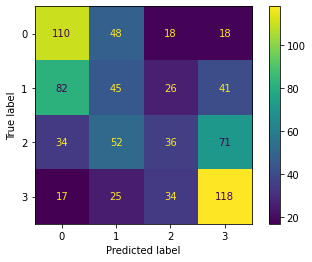

In [17]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

plot_confusion_matrix(estimator =forest_RF, X = X_test_RF, y_true = y_test_RF )
y_pred = forest_RF.predict(X_test_RF)
accuracy_score(y_test_RF, y_pred)

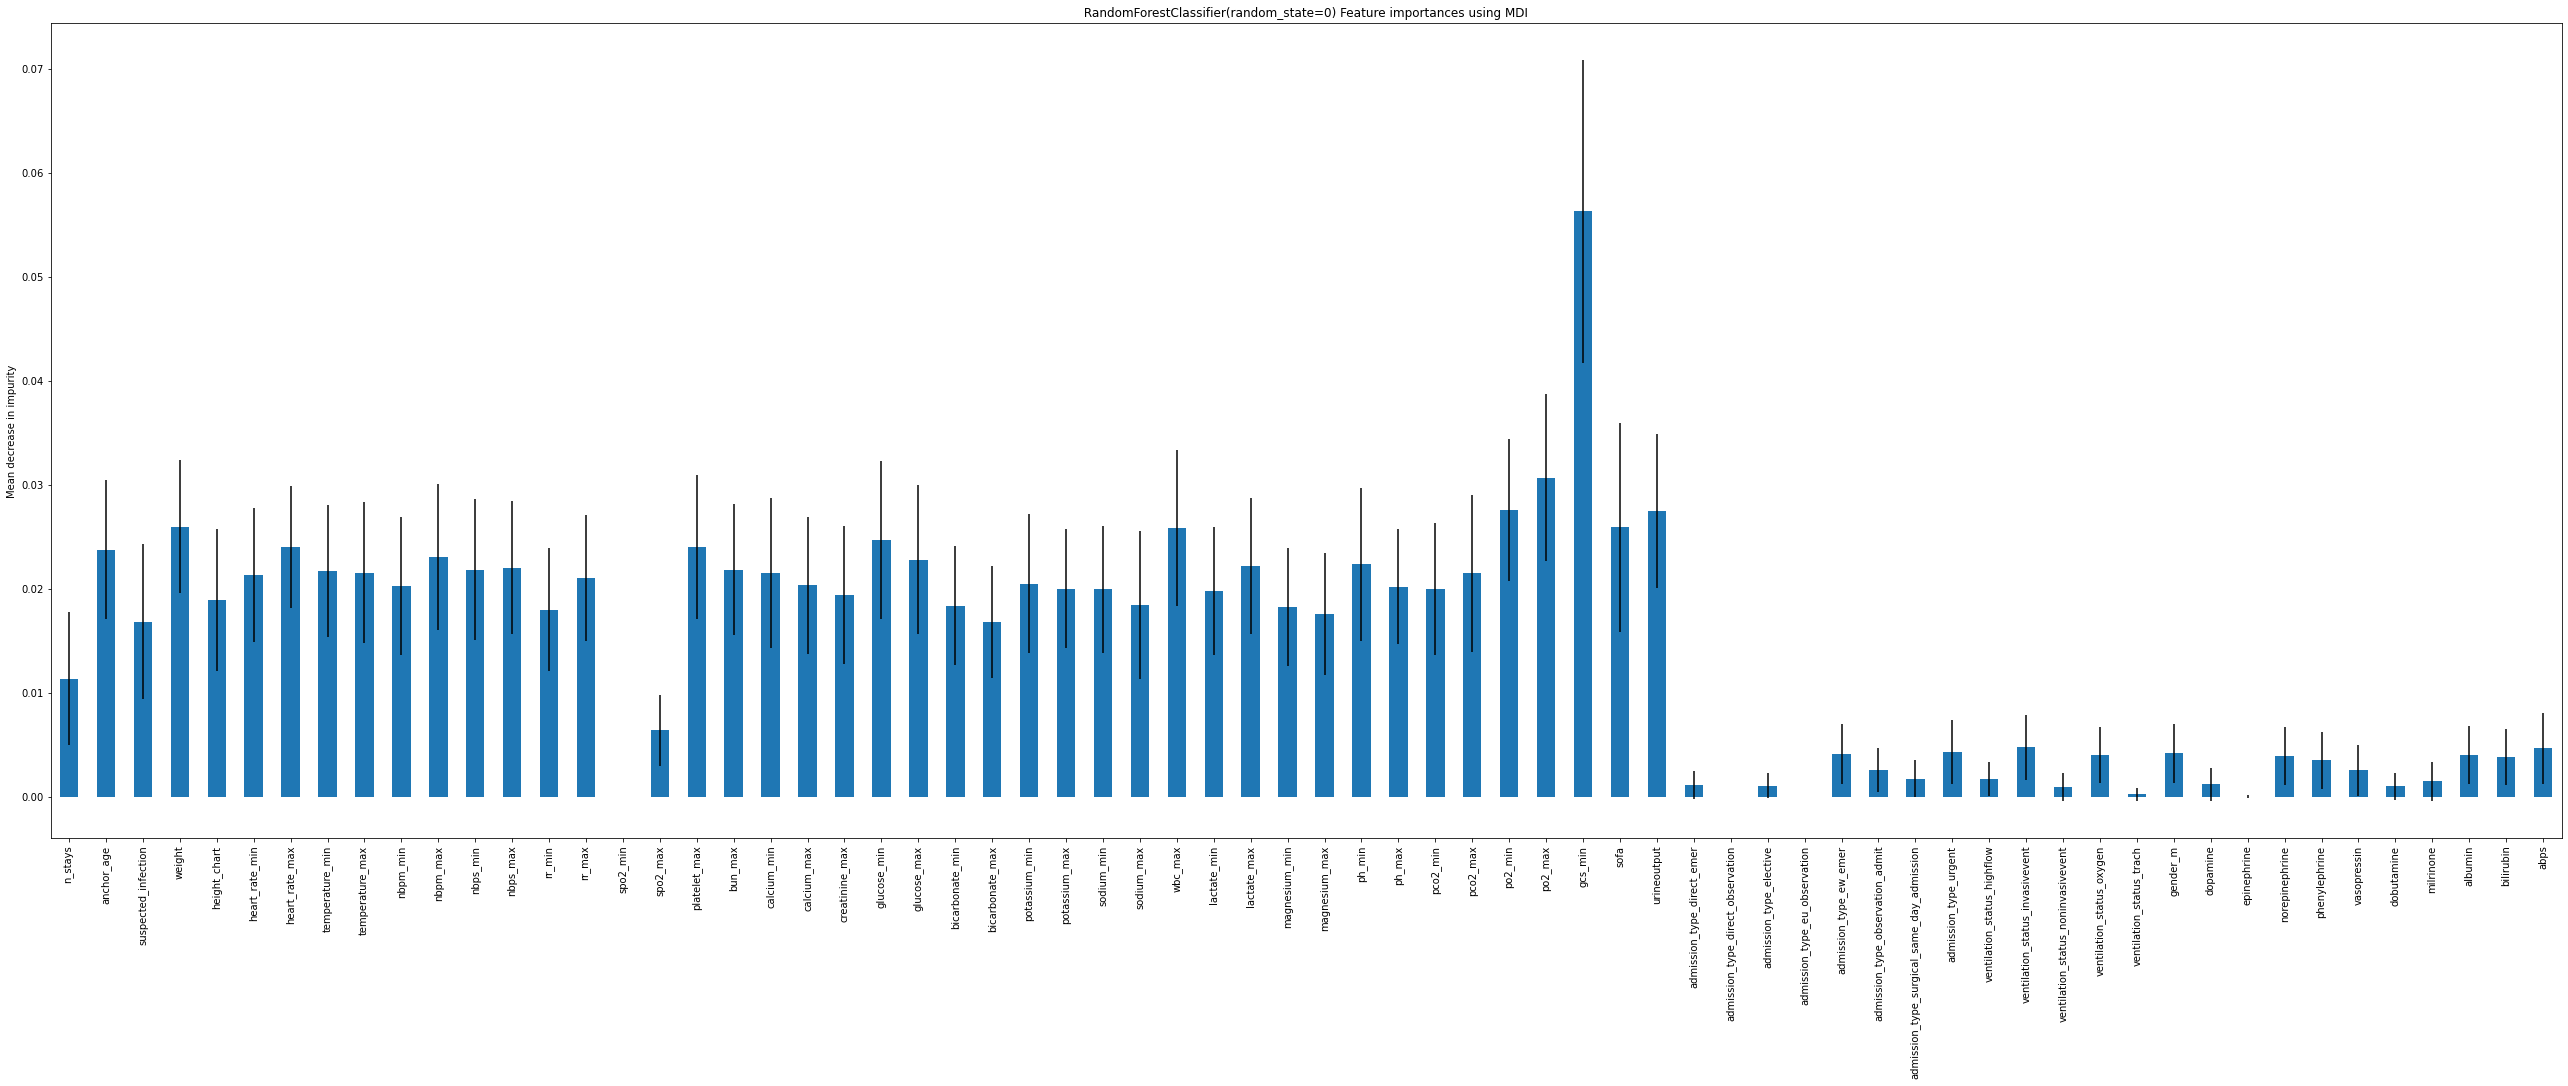

In [18]:
impurityPlot(feature_names_RF,forest_RF)

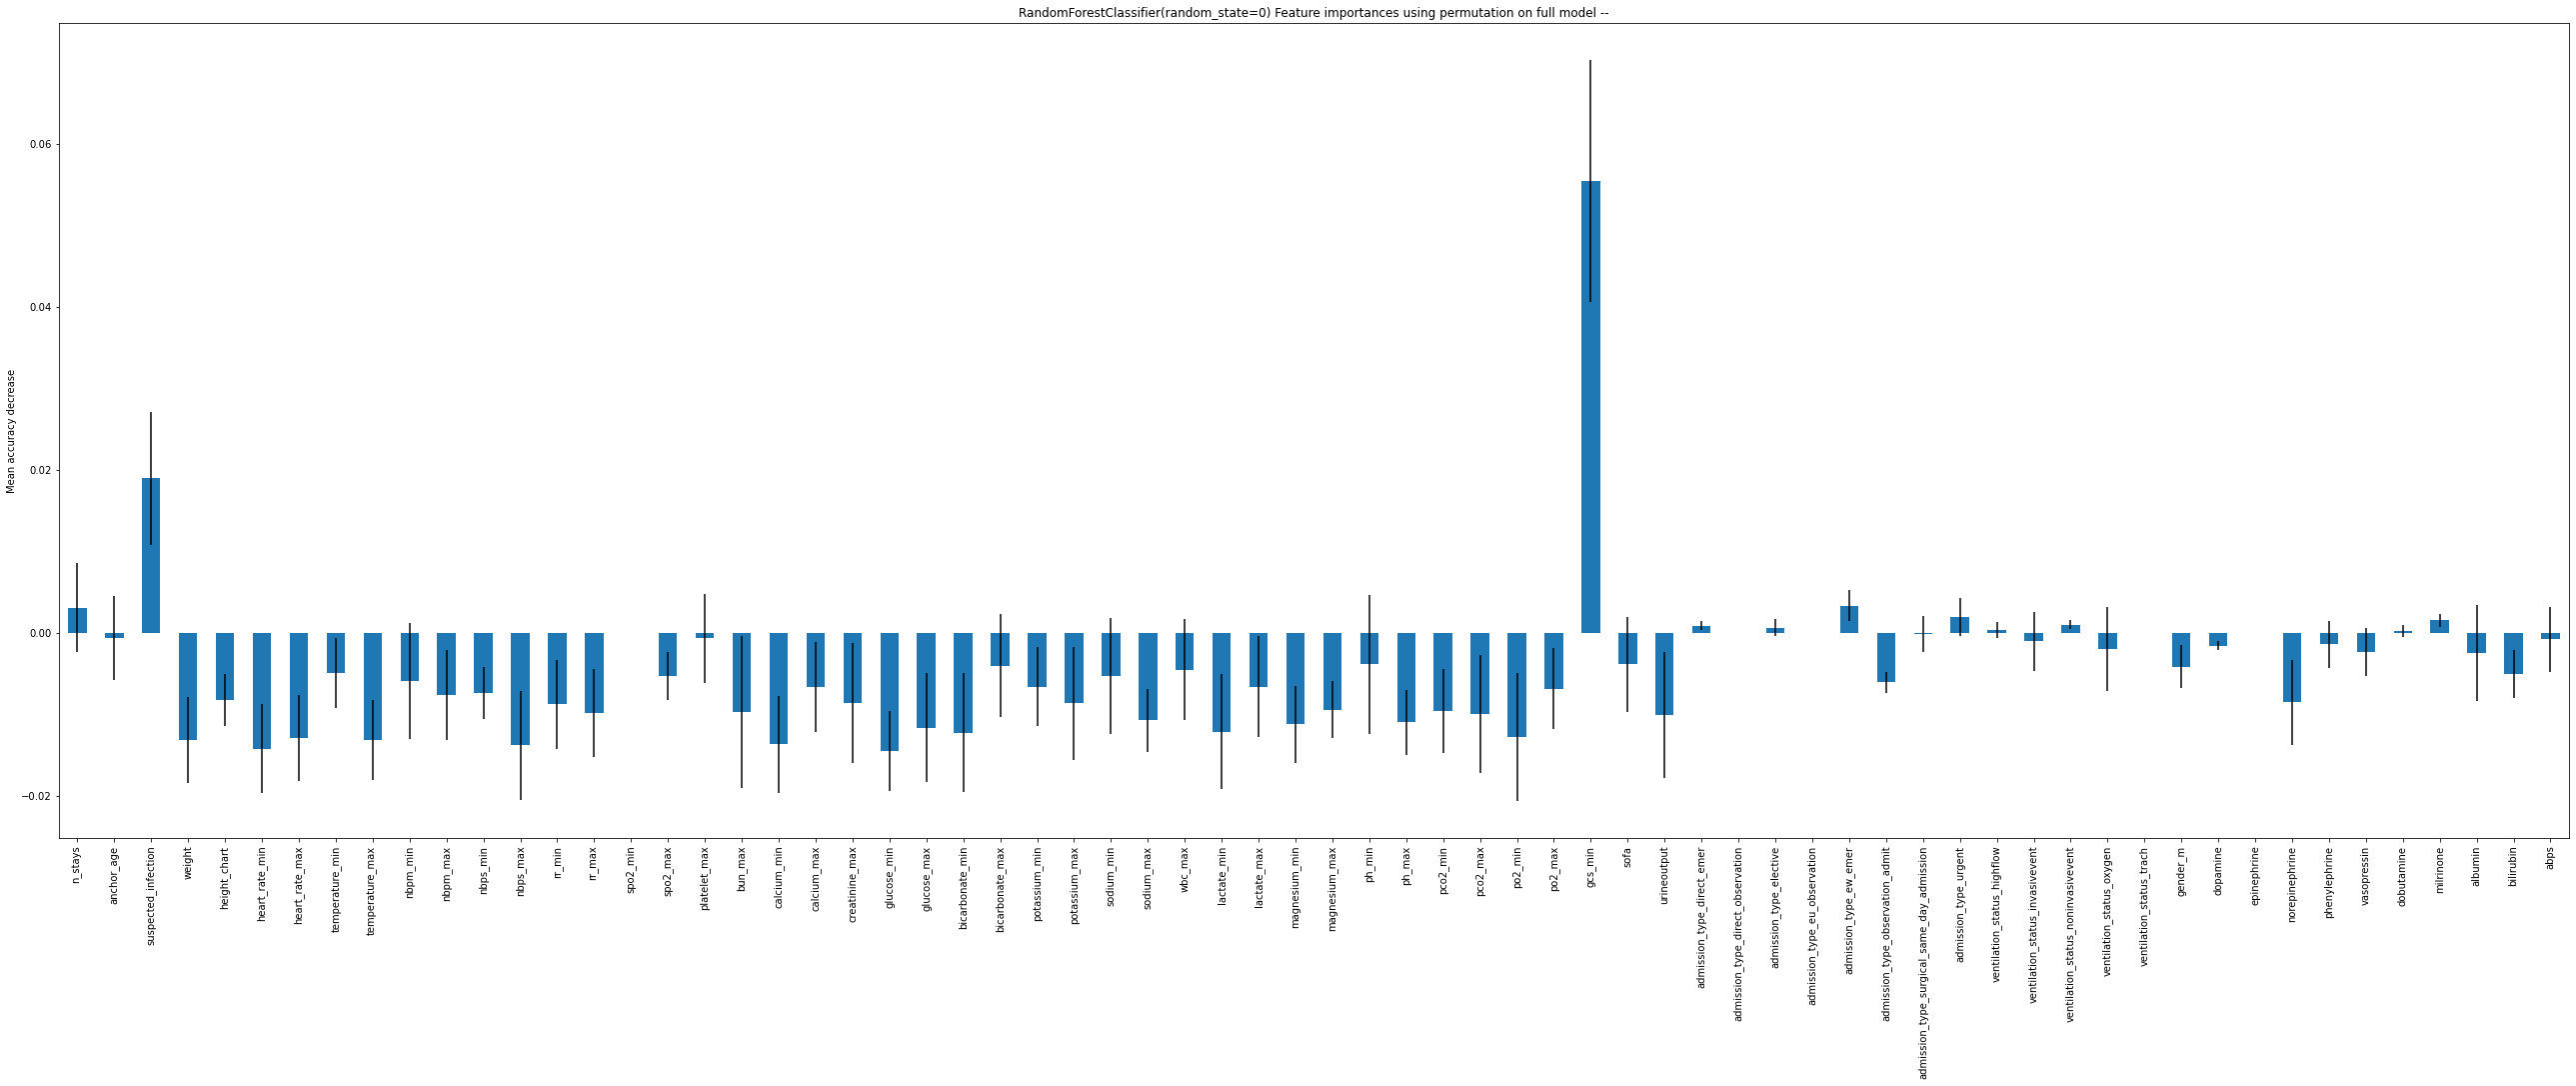

In [19]:
permutationPlot(feature_names_RF,forest_RF, X_test_RF, y_test_RF)

### Feature Importance Analysis using Linear Regression

In [20]:
y = labels
feature_names_LR, model_LR, X_test_LR, y_test_LR = LinearRegressionFit(X,y)

In [21]:
from sklearn import metrics
y_pred = forest_RF.predict(X_test_LR)
print(f" Mean Absolute Error of this LR model is: {metrics.mean_absolute_error(y_test_LR, y_pred)}")
print(f" Mean Squared Error of this LR model is: {metrics.mean_squared_error(y_test_LR, y_pred)}")

 Mean Absolute Error of this LR model is: 8.35219625149343
 Mean Squared Error of this LR model is: 132.42169272652256


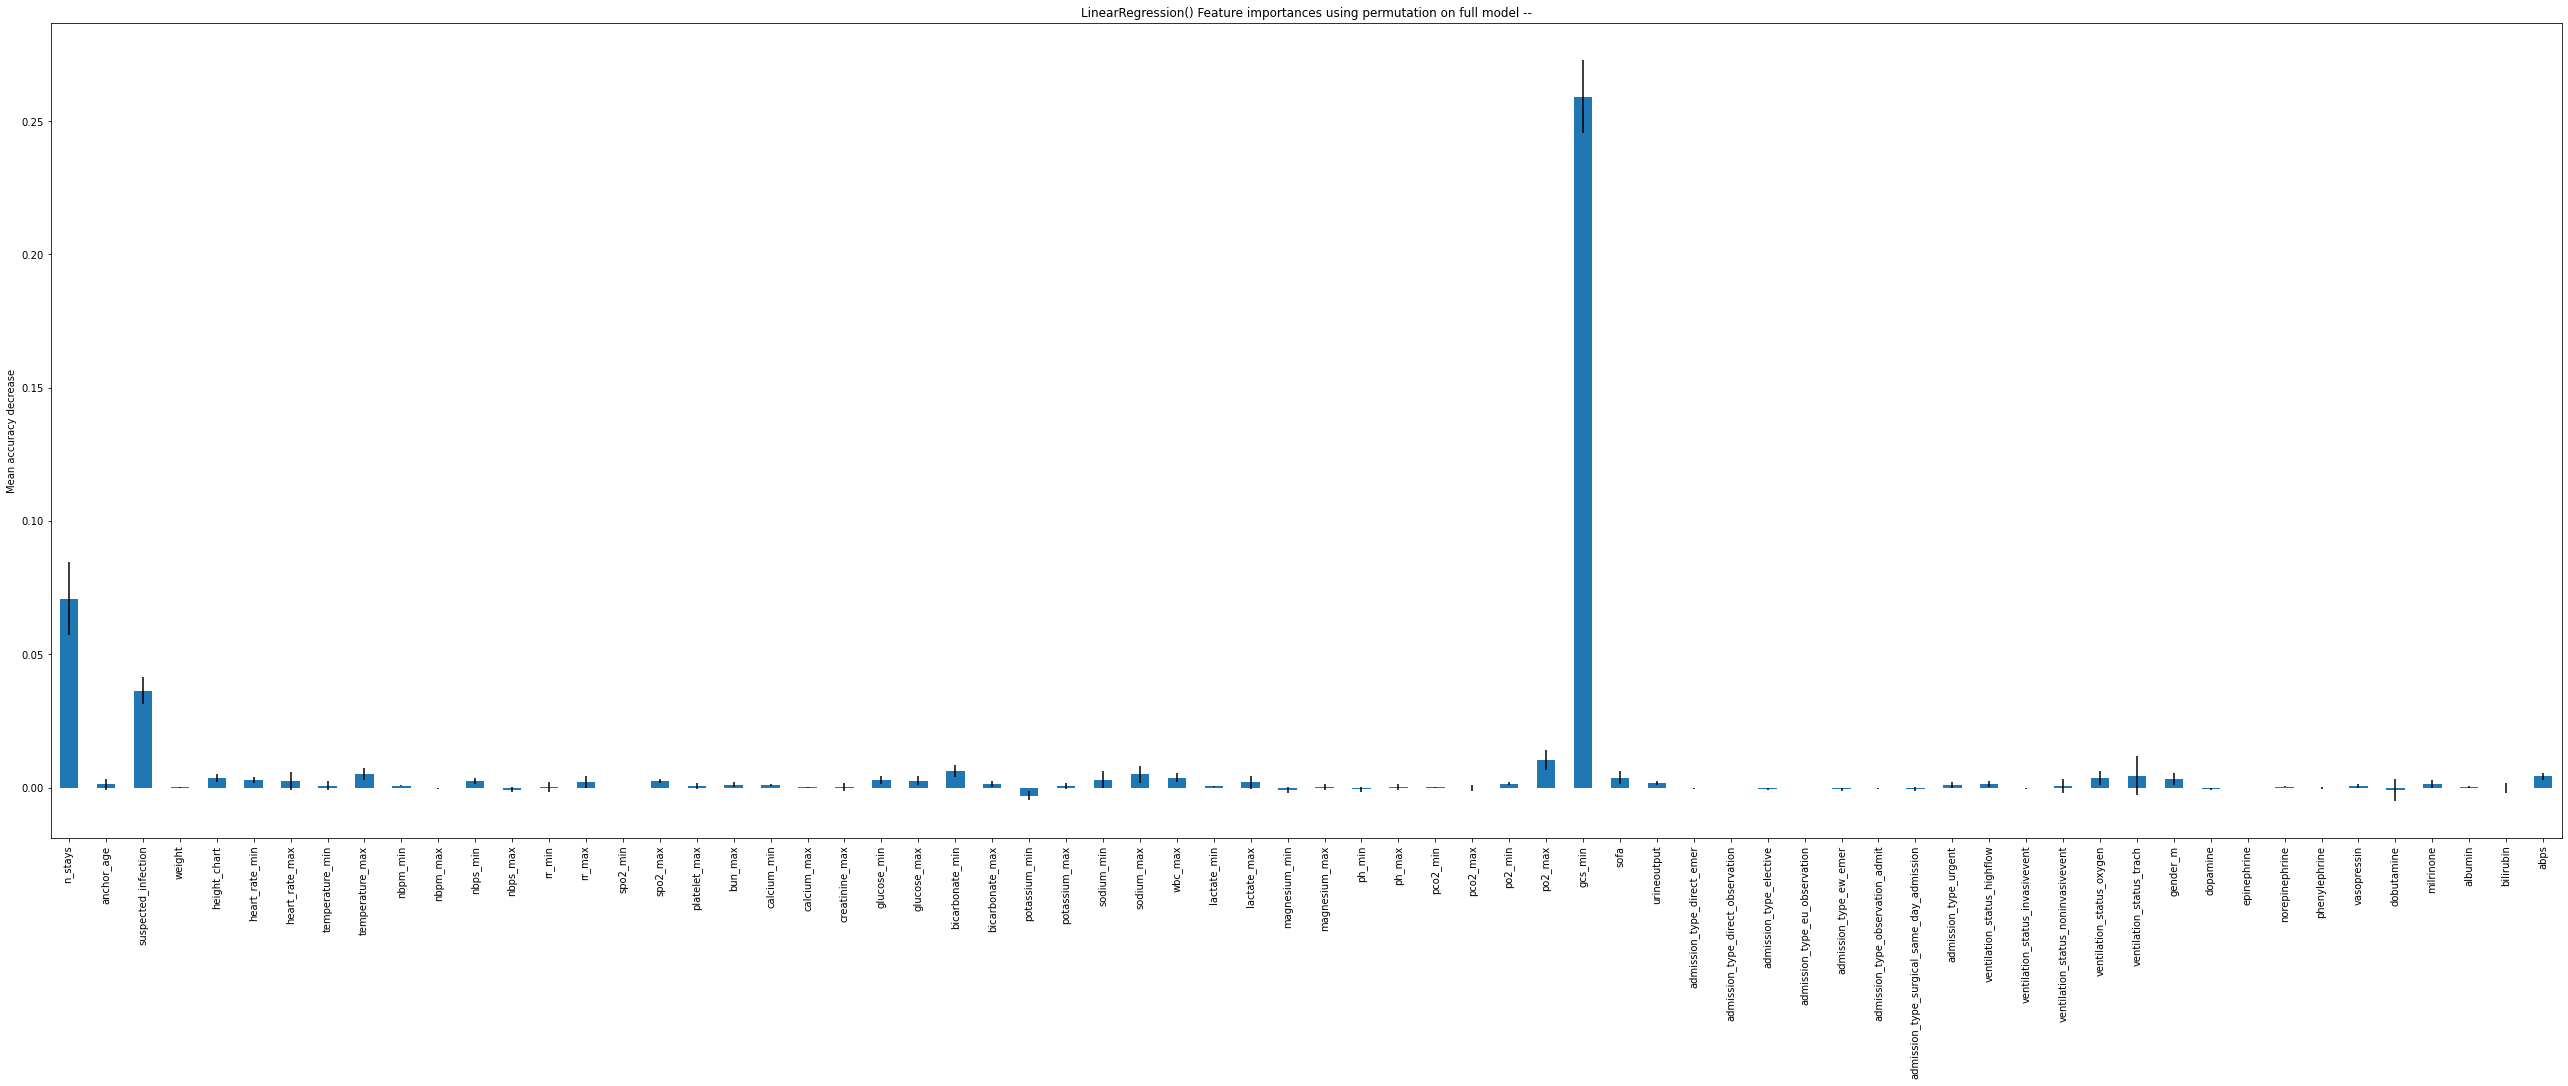

In [22]:
permutationPlot(feature_names_LR,model_LR, X_test_LR, y_test_LR)